# Stock market forecasting using Time Series analysis With ARIMA model.

In [ ]:
pip install pmdarima

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib as mtp
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

use the read_csv() in pandas package to read the time series dataset as a pandas dataframe. Adding the parse_dates=['date'] argument will make the date column to be parsed as a date field.

# Next step is importing Train data.

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
nse_train = pd.read_csv("NSE Training Data - 1st Jan 2016 to 1st Jan 2022 (1).csv", index_col='Date', parse_dates=['Date'], date_parser=dateparse).dropna(0)
nse_train.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,7924.549805,7937.549805,7781.100098,7791.299805,7791.299805,134700.0
2016-01-05,7828.399902,7831.200195,7763.250000,7784.649902,7784.649902,145200.0
2016-01-06,7788.049805,7800.950195,7721.200195,7741.000000,7741.000000,147100.0
2016-01-07,7673.350098,7674.950195,7556.600098,7568.299805,7568.299805,188900.0
2016-01-08,7611.649902,7634.100098,7581.049805,7601.350098,7601.350098,157400.0


# Next step is importing Test data.

In [3]:
nse_test=pd.read_csv("NSE Out of Time Testing Data - 1st Jan 2022 to 4th Feb 2022 (1).csv", index_col='Date', parse_dates=['Date'], date_parser=dateparse).dropna()
nse_test.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,17387.150391,17646.650391,17383.300781,17625.699219,17625.699219,200500
2022-01-04,17681.400391,17827.599609,17593.550781,17805.250000,17805.250000,247400
2022-01-05,17820.099609,17944.699219,17748.849609,17925.250000,17925.250000,251500
2022-01-06,17768.500000,17797.949219,17655.550781,17745.900391,17745.900391,236500
2022-01-07,17797.599609,17905.000000,17704.550781,17812.699219,17812.699219,239300


In [4]:
nse_train.shape

(1475, 6)

In [5]:
nse_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1475 entries, 2016-01-04 to 2021-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1475 non-null   float64
 1   High       1475 non-null   float64
 2   Low        1475 non-null   float64
 3   Close      1475 non-null   float64
 4   Adj Close  1475 non-null   float64
 5   Volume     1475 non-null   float64
dtypes: float64(6)
memory usage: 80.7 KB


In [6]:
nse_train.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1475.000000,1475.000000,1475.000000,1475.000000,1475.000000,1.475000e+03
mean,11190.630103,11243.279798,11114.862019,11180.224847,11180.224847,3.672148e+05
std,2605.404423,2613.649325,2588.183872,2602.005796,2602.005796,2.277599e+05
min,7023.649902,7034.200195,6825.799805,6970.600098,6970.600098,0.000000e+00
25%,9362.950195,9404.100098,9290.100097,9315.899902,9315.899902,1.956000e+05
50%,10781.849609,10816.349609,10718.750000,10769.150391,10769.150391,2.906000e+05
75%,11925.699707,11968.899903,11847.475097,11914.125000,11914.125000,5.092500e+05
max,18602.349609,18604.449219,18445.300781,18477.050781,18477.050781,1.811000e+06


In [7]:
for col in nse_train:
    print(col)
    print(nse_train[col].value_counts())

Open
10742.700195    2
9908.150391     2
11939.099609    2
10930.900391    2
11464.950195    2
               ..
8818.549805     1
9163.900391     1
10986.799805    1
13741.900391    1
11678.450195    1
Name: Open, Length: 1466, dtype: int64
High
11058.049805    2
8178.700195     2
11398.150391    2
9377.099609     2
10637.799805    2
               ..
15190.000000    1
10075.250000    1
10426.099609    1
9602.200195     1
10766.250000    1
Name: High, Length: 1467, dtype: int64
Low
8407.049805     2
11366.900391    2
10620.400391    2
10141.549805    2
11370.799805    2
               ..
11823.200195    1
13402.849609    1
9119.750000     1
8741.049805     1
8909.400391     1
Name: Low, Length: 1465, dtype: int64
Close
11588.349609    2
11346.200195    2
11844.099609    2
11669.150391    2
11278.900391    2
               ..
8253.799805     1
11476.950195    1
9261.950195     1
8926.900391     1
16770.849609    1
Name: Close, Length: 1459, dtype: int64
Adj Close
11588.349609    2
1134

In Volume column We can see some Zero values, let's replace with it's mean

In [9]:
nse_train['Volume']=nse_train['Volume'].replace(0.0,nse_train['Volume'].mean())

In [10]:
for col in nse_train:
    print(col)
    print(nse_train[col].value_counts())

Open
10742.700195    2
9908.150391     2
11939.099609    2
10930.900391    2
11464.950195    2
               ..
8818.549805     1
9163.900391     1
10986.799805    1
13741.900391    1
11678.450195    1
Name: Open, Length: 1466, dtype: int64
High
11058.049805    2
8178.700195     2
11398.150391    2
9377.099609     2
10637.799805    2
               ..
15190.000000    1
10075.250000    1
10426.099609    1
9602.200195     1
10766.250000    1
Name: High, Length: 1467, dtype: int64
Low
8407.049805     2
11366.900391    2
10620.400391    2
10141.549805    2
11370.799805    2
               ..
11823.200195    1
13402.849609    1
9119.750000     1
8741.049805     1
8909.400391     1
Name: Low, Length: 1465, dtype: int64
Close
11588.349609    2
11346.200195    2
11844.099609    2
11669.150391    2
11278.900391    2
               ..
8253.799805     1
11476.950195    1
9261.950195     1
8926.900391     1
16770.849609    1
Name: Close, Length: 1459, dtype: int64
Adj Close
11588.349609    2
1134

# Next is plot all columns in dataset

Text(0.5, 1.0, 'Date vs Volume')

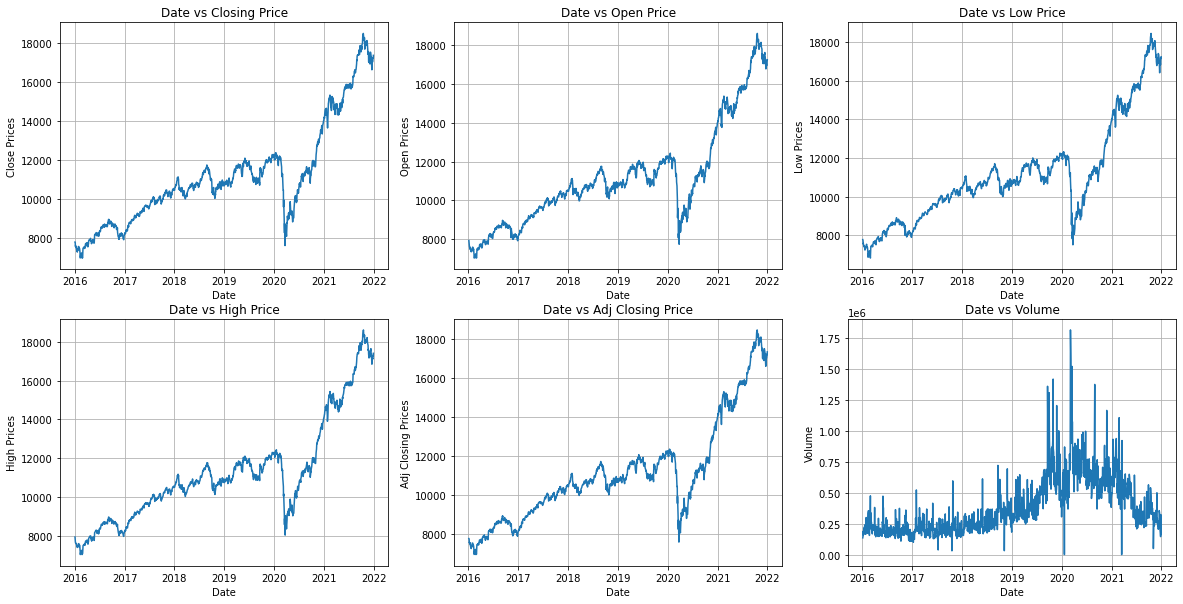

In [11]:
plt.figure(figsize=(20,10))        
           
plt.subplot(2,3,1)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(nse_train['Close'])
plt.title('Date vs Closing Price')


plt.subplot(2,3,2)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Open Prices')
plt.plot(nse_train['Open'])
plt.title('Date vs Open Price')


plt.subplot(2,3,3)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Low Prices')
plt.plot(nse_train['Low'])
plt.title('Date vs Low Price')


plt.subplot(2,3,4)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('High Prices')
plt.plot(nse_train['High'])
plt.title('Date vs High Price')


plt.subplot(2,3,5)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Adj Closing Prices')
plt.plot(nse_train['Adj Close'])
plt.title('Date vs Adj Closing Price')


plt.subplot(2,3,6)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.plot(nse_train['Volume'])
plt.title('Date vs Volume')

Next step is to find the distribution of the Close Points and shows how the values are distributed.

<AxesSubplot:ylabel='Density'>

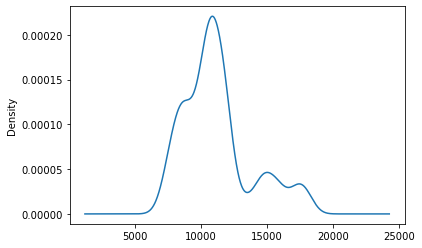

In [12]:
df_close =nse_train['Close']
df_close.plot(kind='kde')

# stationarity check

In the most intuitive sense, stationarity means that the statistical properties of a process generating a time series do not change over time . It does not mean that the series does not change over time, just that the way it changes does not itself change over time.
Statistical properties means Important potential properties of statistics include completeness, consistency, sufficiency, unbiasedness, minimum mean square error, low variance, robustness, and computational convenience.

A rolling analysis of a time series model is often used to assess the model's stability over time. When analyzing financial time series data using a statistical model, a key assumption is that the parameters of the model are constant over time

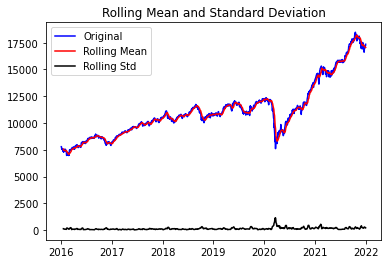

Results of dickey fuller test
Test Statistics                   0.001453
p-value                           0.958652
No. of lags used                 11.000000
Number of observations used    1463.000000
critical value (1%)              -3.434828
critical value (5%)              -2.863518
critical value (10%)             -2.567823
dtype: float64


In [13]:

    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

# Decompose Time Series Data into Trend and Seasonality
These components are defined as follows:
Level: The average value in the series.
Trend: The increasing or decreasing value in the series.
Seasonality: The repeating short-term cycle in the series.
Noise: The random variation in the series
Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

Additive Model An additive model suggests that the components are added together as follows:
y(t) = Level + Trend + Seasonality + Noise
A multiplicative model suggests that the components are multiplied together as follows:
y(t) = Level * Trend * Seasonality * Noise

# Multiplicative
A multiplicative model suggests that the components are multiplied together as follows:

y(t) = Level * Trend * Seasonality * Noise
A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.

A nonlinear trend is a curved line.

A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

<Figure size 432x288 with 0 Axes>

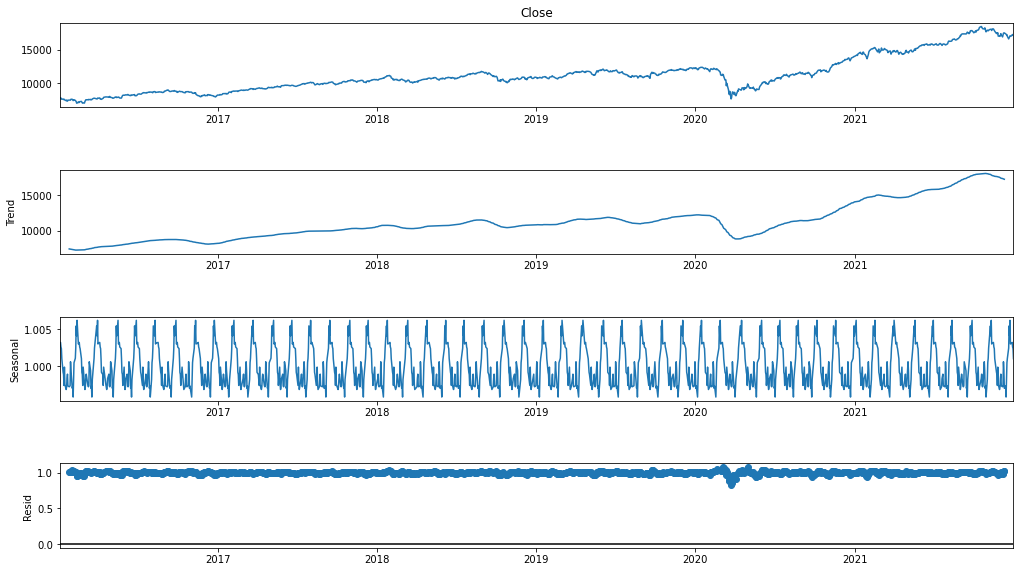

In [14]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

# Additive Model
An additive model suggests that the components are added together as follows:

y(t) = Level + Trend + Seasonality + Noise
An additive model is linear where changes over time are consistently made by the same amount.

A linear trend is a straight line.

A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

<Figure size 432x288 with 0 Axes>

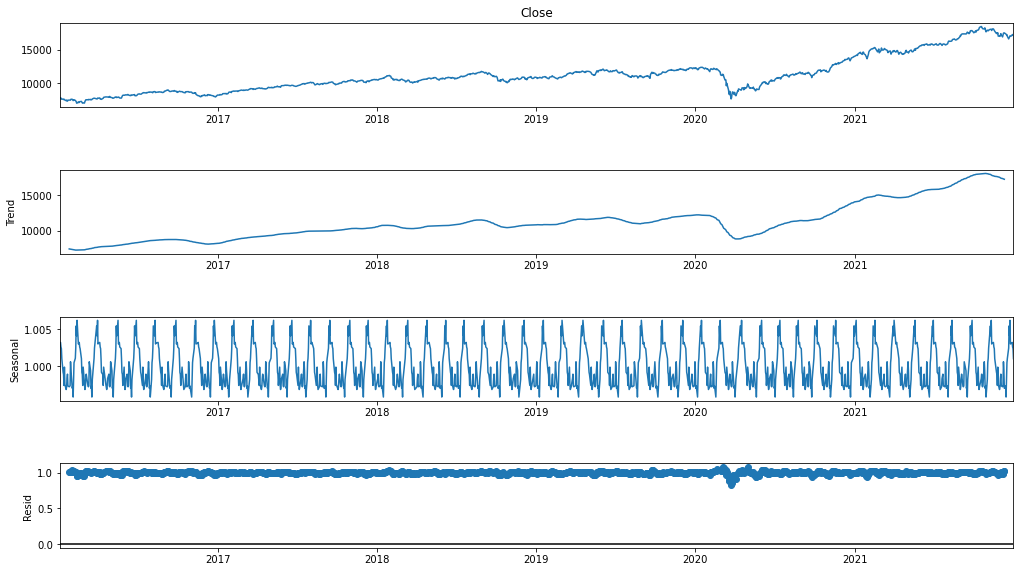

In [15]:
result = seasonal_decompose(df_close, model='Additive', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

not stationary then eliminate trend

# Eliminate trend

No handles with labels found to put in legend.


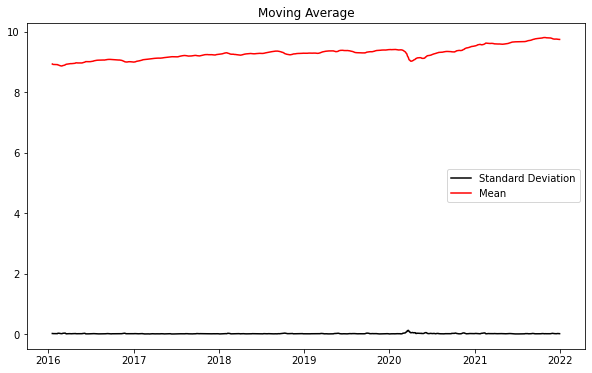

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [17]:
train_data=df_log

# Distribution of the dataset

In [18]:
df_close1 =nse_test['Close']
df_log1 = np.log(df_close1)

In [19]:
test_data=df_log1

In [20]:
print("Train shape",train_data.shape)
print("Test shape",test_data.shape)

Train shape (1475,)
Test shape (23,)


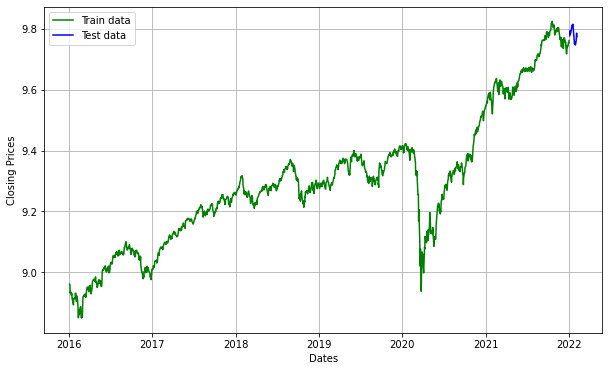

In [21]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

# Autoregressive integrated moving average ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9026.321, Time=2.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9026.724, Time=0.73 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9026.616, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9024.922, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9025.313, Time=0.98 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9024.956, Time=0.61 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9024.168, Time=0.92 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-9025.052, Time=0.30 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 6.978 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1475
Model:               SARIMAX(1, 1, 0)   Log Likelihood                4516.362
Date:                Tue, 08 Feb 2022   AIC                          -9026.724
Time:                       

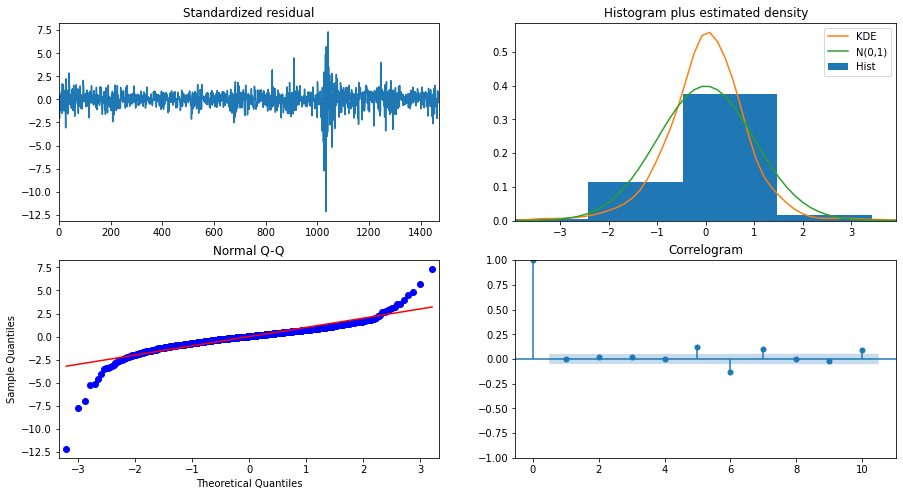

In [22]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

# Modeling
Build Model

In [23]:
model = ARIMA(train_data, order=(0,1,1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

C:\Users\Think\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Think\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1474
Model:                 ARIMA(0, 1, 1)   Log Likelihood                4516.312
Method:                       css-mle   S.D. of innovations              0.011
Date:                Tue, 08 Feb 2022   AIC                          -9026.625
Time:                        19:39:15   BIC                          -9010.737
Sample:                             1   HQIC                         -9020.701
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.000      1.919      0.055   -1.15e-05       0.001
ma.L1.D.Close    -0.0387      0.025     -1.521      0.128      -0.088       0.011
                                    Root

# Next is to plot the residuals to ensure there are no patterns

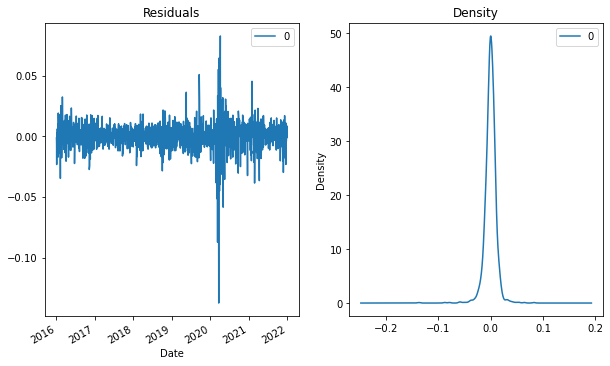

In [24]:
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using plot_predict()

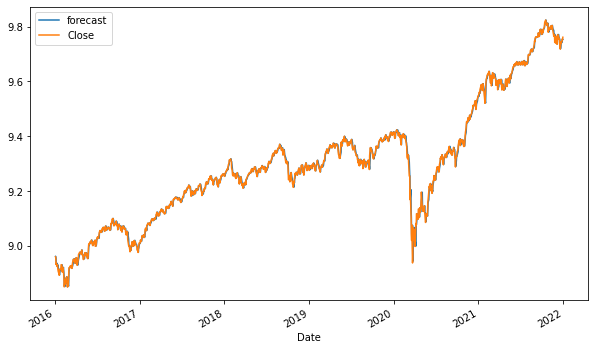

In [25]:
# Actual vs Fitted
fitted.plot_predict(dynamic=False)
plt.show()

In [26]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
nse_train = df_close[:]
nse_test = df_close1[:]

# 95% conf
Let’s now begin forecasting stock prices on the test dataset with a 95% confidence level.

In [27]:
fc, se, conf = fitted.forecast(23, alpha=0.05)  


# Make as pandas series


In [28]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)


# Plot training data,Actual Stock Price,Predicted Stock Price.

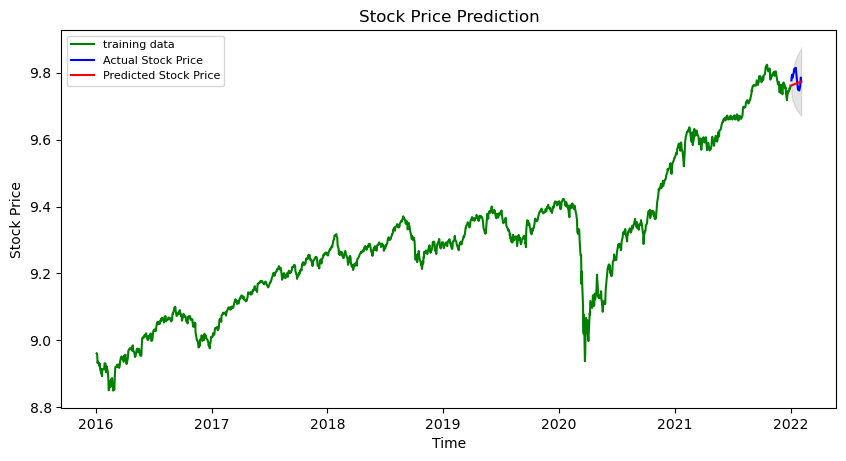

In [29]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data,color='g',label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'red',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Report performance
Let’s take a look at some of the most common accuracy metrics for evaluating forecast results:

In [30]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.0007860053534456931
MAE: 0.02447254866903909
RMSE: 0.02803578701313186
MAPE: 0.0024992081957889403


With a MAPE of around .24%, the model is 99.76% accurate in predicting.